In [ ]:
!pip install hyperas

In [2]:
import h5py
from os.path import join,exists
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from hyperas.distributions import choice
from hyperas import optim
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from random import randint
from keras import backend as K
import os
import numpy as np
from sklearn.utils import shuffle
from hyperopt import Trials, STATUS_OK, tpe
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
K.set_image_data_format('channels_first')

In [3]:
os.chdir('/content/drive/My Drive/Colab Notebooks/synopsys-2022/models/regression')

In [17]:
class_model = keras.models.load_model('../classification/seq_32_32')

In [4]:
# increase depth
# expand width (32 -> 64)
# relu -> leakyrelu, elu
# parallel sequential model (maybe?)
# same -> valid?

def create_model(X_train, Y_train, X_test, Y_test):
    W_maxnorm = 3
    DROPOUT = {{choice([0.3,0.5,0.7])}}
    # DROPOUT = 0.3

    model = Sequential()
    model.add(Conv2D(64, (1, 5), padding='same', input_shape=(20, 1, 20),activation='relu',kernel_constraint=maxnorm(W_maxnorm)))
    model.add(MaxPool2D(pool_size=(1, 2),strides=(1,2)))
    model.add(Conv2D(128, (1, 5), padding='same', activation='relu',kernel_constraint=maxnorm(W_maxnorm)))
    model.add(MaxPool2D(pool_size=(1, 2),strides=(1,2)))
    model.add(Flatten())

    model.add(Dense(16,activation='relu',kernel_constraint=maxnorm(W_maxnorm), kernel_regularizer='l1'))
    model.add(Dropout(DROPOUT))
    #model.add(Dense(2,W_constraint=maxnorm(W_maxnorm)))
    #model.add(Activation('softmax'))
    model.add(Dense(1))

    # change optimizer to Adam

    # myoptimizer = RMSprop(lr={{choice([0.01,0.001,0.0001,1e-5,1e-1])}}, rho=0.9, epsilon=1e-06)
    # myoptimizer = RMSprop(lr=0.01, rho=0.9, epsilon=1e-06)
    #mylossfunc = 'binary_crossentropy'
    mylossfunc='mean_squared_error'
    model.compile(loss=mylossfunc, optimizer='adam')
    # print(model.summary())

    result = model.fit(X_train, Y_train, batch_size=100, epochs=5,validation_split=0.1,verbose=False)

    val_loss = np.amax(result.history['val_loss'])
    # model_arch = 'MODEL_ARCH'
    # bestaccfile = join('TOPDIR',model_arch,model_arch+'_hyperbestacc')
    # reportAcc(acc,score,bestaccfile)

    return {'loss': val_loss, 'status': STATUS_OK, 'model': model}

In [5]:
def train_data():
  data_train = h5py.File('./data/train.h5.batch1','r')
  X_train = np.array(data_train['data'])
  Y_train = np.array(data_train['label'])
  X_train_shuffled, Y_train_shuffled = shuffle(X_train, Y_train)

  data_test = h5py.File('./data/test_new.h5.batch1', 'r')
  X_test = np.array(data_test['data'])
  Y_test = np.array(data_test['label'])
  return X_train_shuffled, Y_train_shuffled, X_test, Y_test

In [6]:
best_run, best_model = optim.minimize(model=create_model,
                                          data=train_data,
                                          algo=tpe.suggest,
                                          max_evals=10,
                                          trials=Trials(),
                                          notebook_name='seq_32x1_16',
                                          verbose=False)

100%|██████████| 10/10 [01:37<00:00,  9.71s/it, best loss: 0.2566092312335968]


In [7]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 1, 20)         6464      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 1, 10)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 1, 10)        41088     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 1, 5)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 16)                1

In [9]:
X_train, Y_train, X_test, Y_test = train_data()
best_model.fit(X_train, Y_train, batch_size=100, epochs=50,validation_split=0.1,verbose=True)

Epoch 1/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3170 - val_loss: 0.2773
Epoch 2/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3150 - val_loss: 0.2836
Epoch 3/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3112 - val_loss: 0.2801
Epoch 4/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3124 - val_loss: 0.2893
Epoch 5/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3122 - val_loss: 0.2825
Epoch 6/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3099 - val_loss: 0.2875
Epoch 7/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3082 - val_loss: 0.2853
Epoch 8/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3084 - val_loss: 0.2908
Epoch 9/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3079 - val_loss: 0.2897
Epoch 10/40
571/571 [==============================] - 2s 3ms/step - loss: 0.3073 - val_loss: 0.2924

In [14]:
Y_test.shape

(22690,)

(array([2.000e+00, 5.000e+00, 1.300e+01, 1.600e+01, 5.900e+01, 1.320e+02,
        3.170e+02, 5.010e+02, 1.023e+03, 1.141e+03, 1.723e+03, 2.460e+03,
        2.226e+03, 2.921e+03, 3.150e+03, 2.506e+03, 2.280e+03, 2.771e+03,
        3.328e+03, 4.138e+03, 2.194e+03, 5.849e+03, 2.618e+03, 2.692e+03,
        2.658e+03, 2.103e+03, 1.908e+03, 1.517e+03, 1.107e+03, 8.170e+02,
        5.570e+02, 1.720e+02, 3.300e+01, 7.900e+01, 1.210e+02, 1.330e+02,
        2.040e+02, 1.340e+02, 2.430e+02, 2.050e+02, 1.600e+02, 4.450e+02,
        3.280e+02, 3.080e+02, 2.173e+03, 1.203e+03, 1.650e+02, 7.090e+02,
        4.950e+02, 3.290e+02, 3.440e+02, 1.880e+02, 1.230e+02, 1.270e+02,
        7.700e+01, 5.500e+01, 3.700e+01, 3.700e+01, 2.600e+01, 1.500e+01]),
 array([-2.3926847 , -2.31954776, -2.24641083, -2.17327389, -2.10013695,
        -2.02700002, -1.95386308, -1.88072615, -1.80758921, -1.73445227,
        -1.66131534, -1.5881784 , -1.51504147, -1.44190453, -1.3687676 ,
        -1.29563066, -1.22249372, -1.14

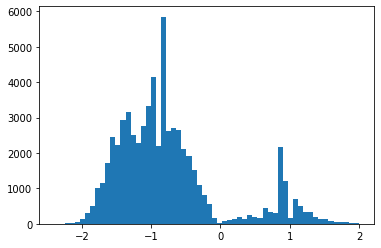

In [16]:
plt.hist(Y_train, bins=60)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 8.000e+00, 1.100e+01, 2.600e+01, 2.700e+01,
        3.700e+01, 5.600e+01, 8.600e+01, 1.580e+02, 3.650e+02, 7.370e+02,
        1.133e+03, 1.633e+03, 1.817e+03, 2.377e+03, 1.834e+03, 1.871e+03,
        1.575e+03, 1.182e+03, 1.051e+03, 7.210e+02, 7.310e+02, 5.880e+02,
        8.800e+01, 1.090e+02, 1.330e+02, 8.900e+01, 1.130e+02, 8.600e+01,
        8.900e+01, 1.090e+02, 9.300e+01, 1.370e+02, 1.710e+02, 2.260e+02,
        2.450e+02, 3.860e+02, 3.140e+02, 5.820e+02, 3.290e+02, 3.200e+02,
        3.890e+02, 2.930e+02, 1.500e+02, 1.090e+02, 5.500e+01, 3.100e+01,
        6.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([-2.67582639, -2.58786459, -2.4999028 , -2.411941  , -2.32397921,
        -2.23601741, -2.14805561, -2.06009382, -1.97213202, -1.88417023,
        -1.79620843, -1.70824664, -1.62028484, -1.53232304, -1.44436125,
        -1.35639945, -1.26843766, -1.18

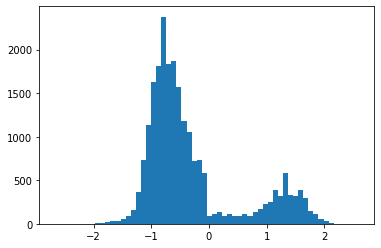

In [15]:
plt.hist(Y_test, bins=60)

In [11]:
best_model.evaluate(X_test, Y_test)

710/710 [==============================] - 1s 2ms/step - loss: 0.3530


0.3530241549015045

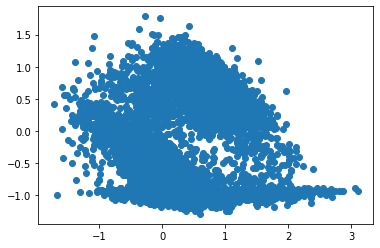

In [10]:
Y_pred = best_model.predict(X_test)
residuals = Y_test - Y_pred.flatten()
plt.scatter(residuals, Y_pred.flatten())

(array([5.000e+00, 1.400e+01, 6.800e+01, 3.020e+02, 1.003e+03, 2.346e+03,
        5.169e+03, 7.629e+03, 3.360e+02, 2.600e+02, 2.110e+02, 1.570e+02,
        1.360e+02, 1.210e+02, 9.400e+01, 1.180e+02, 9.300e+01, 6.900e+01,
        8.800e+01, 9.300e+01, 7.000e+01, 5.800e+01, 7.400e+01, 7.100e+01,
        6.100e+01, 6.000e+01, 8.900e+01, 1.220e+02, 1.360e+02, 1.330e+02,
        1.570e+02, 1.720e+02, 1.750e+02, 1.850e+02, 2.210e+02, 2.390e+02,
        2.690e+02, 2.850e+02, 2.730e+02, 3.070e+02, 2.470e+02, 2.370e+02,
        1.870e+02, 1.430e+02, 1.060e+02, 8.000e+01, 5.600e+01, 6.000e+01,
        3.100e+01, 2.000e+01, 2.000e+01, 1.400e+01, 6.000e+00, 5.000e+00,
        5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([-1.2925892 , -1.2412741 , -1.1899589 , -1.1386439 , -1.0873287 ,
        -1.0360136 , -0.9846984 , -0.9333833 , -0.8820682 , -0.8307531 ,
        -0.77943796, -0.72812283, -0.6768077 , -0.6254926 , -0.57417744,
        -0.5228623 , -0.4715472 , -0.42

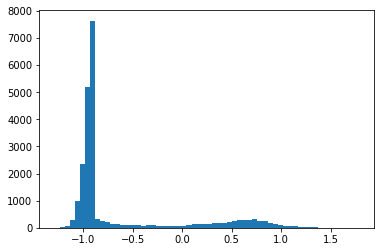

In [19]:
plt.hist(Y_pred.flatten(),bins=60)